In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import FileLink
FileLink('./data_cleanup.ipynb')

/Users/jing/Documents/LambdaSchool/lambda_lab/notebooks/data_cleanup.ipynb

In [4]:
df = pd.read_sql_table('data', 'sqlite:///../data/mydb.db')  

In [5]:
df.head(3)

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
0,0,Bujumbura,Maize,Burundi,2011-10-04,NaN,548798.0,BIF,2011.0,10.0,4.0,40.0
1,1,Bujumbura,Maize,Burundi,2011-10-05,NaN,549000.0,BIF,2011.0,10.0,5.0,40.0
2,2,Bujumbura,Maize,Burundi,2011-10-06,NaN,498970.0,BIF,2011.0,10.0,6.0,40.0


In [6]:
# cutoff-date to avoid large data gap, this can be automated later
cutoff_date='2011-09-20'
Market = 'Lira'

date_selected = (df['date']>cutoff_date )
market_selected = (df['market']==Market)
product_selected = ( df['product']=='Maize')

condition = date_selected & market_selected & product_selected
df = df[condition]
df.head()

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
60460,60460,Lira,Maize,Uganda,2011-09-21,NaN,599585.0,UGX,2011.0,9.0,21.0,38.0
60461,60461,Lira,Maize,Uganda,2011-09-22,NaN,658600.0,UGX,2011.0,9.0,22.0,38.0
60462,60462,Lira,Maize,Uganda,2011-09-23,NaN,657473.0,UGX,2011.0,9.0,23.0,38.0
60463,60463,Lira,Maize,Uganda,2011-09-24,NaN,666448.0,UGX,2011.0,9.0,24.0,38.0
60464,60464,Lira,Maize,Uganda,2011-09-27,NaN,648178.0,UGX,2011.0,9.0,27.0,39.0


In [7]:
# remove duplicated row
rows_rm = df.duplicated('date', keep='last')

if np.sum(rows_rm):
    df = df[~rows_rm]
    
print(f'Length of data before removing duplicates: {len(rows_rm)}, after {len(df)}')

Length of data before removing duplicates: 2239, after 1794


In [8]:
retail = df[['date', 'retail']]
retail = retail.sort_values('date')
retail.set_index('date', inplace=True)
retail.tail(10)

,retail
date,
2020-03-03,1200001.0
2020-03-05,1200360.0
2020-03-06,1196448.0
2020-03-10,1198771.0
2020-03-12,1200456.0
2020-03-13,1200656.0
2020-03-17,1205755.0
2020-03-19,1213854.0
2020-03-25,1188807.0


In [9]:
wholesale = df[['date', 'wholesale']].sort_values('date')
wholesale.set_index('date', inplace=True)
wholesale.loc['2011-09-01':'2011-09-30']


,wholesale
date,
2011-09-21,599585.0
2011-09-22,658600.0
2011-09-23,657473.0
2011-09-24,666448.0
2011-09-27,648178.0
2011-09-30,695379.0


In [10]:
# construct complete time frame
date_range = pd.date_range(start=retail.index[0], end=retail.index[-1], freq='D')

time_df=pd.DataFrame([], index=date_range)
time_df.head()

""
2011-09-21
2011-09-22
2011-09-23
2011-09-24
2011-09-25


In [11]:
# construct data sample with complete time frame
yt = time_df.merge(wholesale, how='outer', left_index=True, right_index=True)
yt.tail(10)

,wholesale
2020-03-18,NaN
2020-03-19,930623.0
2020-03-20,NaN
2020-03-21,NaN
2020-03-22,NaN
2020-03-23,NaN
2020-03-24,NaN
2020-03-25,842071.0
2020-03-26,NaN
2020-03-27,868066.0


visualization reveals different trends for different market, let's narrow down

In [12]:
def plot_one_time_series(df, color='k', alpha=1, label=Market):
    """time series of a df with datetime index"""
#     color = [0.1, 0.5, 0.5]
#     color_repeated =np.tile(np.array(color), (df.shape[0],1))
    #print(color_repeated)
    if isinstance(df, (pd.core.frame.DataFrame)):
       
        ax = fig.gca()
        ax.plot(df.index, df.values,#c = color_repeated, 
                color, label=label, alpha=alpha)
        ax.set_xlabel('Year', fontsize=20)
        ax.set_ylabel('Wholesale price by day', fontsize=20)
        ax.tick_params(axis="x", labelsize=20)
        ax.tick_params(axis="y", labelsize=20) 
        ax.legend()
        
    else:
        raise Exception('Wrong type! Plot funiction only take dataframe as input.')

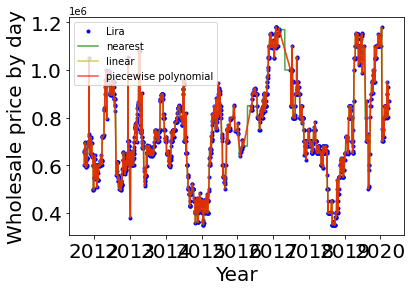

In [13]:
# replace the NaN with interpolated values and visualize for best interpolation method
# since the data is rather ragged, nerest method is picked

yt_n = yt.interpolate(method='nearest')
yt_l = yt.interpolate(method='linear')
yt_pp = yt.interpolate(method='piecewise_polynomial', order=2)

# visualize for best interpolation method
fig = plt.figure()
plot_one_time_series(yt,'b.', label='Lira')
plot_one_time_series(yt_n,'g', label='nearest', alpha=0.7)
plot_one_time_series(yt_l,'y', label='linear', alpha=0.7)
plot_one_time_series(yt_pp,'r', alpha=0.7, label='piecewise polynomial')

plt.show()

y_i = yt_n # y_i: interpolated y

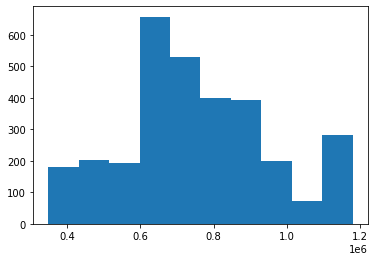

In [14]:
# check the distribution of the data
plt.hist(y_i['wholesale'])
plt.show()

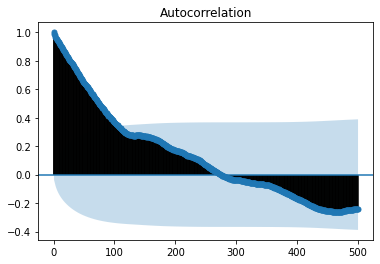

In [15]:
# ACF plot 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_i, lags=500)
plt.show()

In the above correlation plot the cone represents 95% confidence interval.
Notice that we have good positive correlation with the lags upto >700. We cannot use all of those correlations as it will create multi-collinearity problem. Next check on PACF plot to get only the most relevant lags!

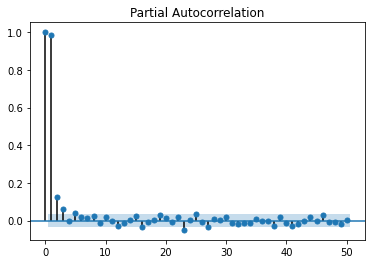

In [16]:
# PACF plot 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_i, lags=50, method='ols')
plt.show()

PACF plots show that lags upto 4 have good correlation before the plot first cuts the upper confidence interval. So for the AR process, use lag 4. 

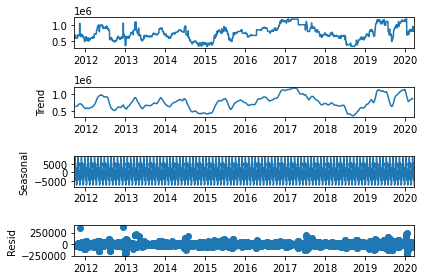

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
period = 30 
s = seasonal_decompose(y_i,
                       period=period,
                       model='additive')

s.plot()
plt.show()

<Figure size 1584x576 with 0 Axes>

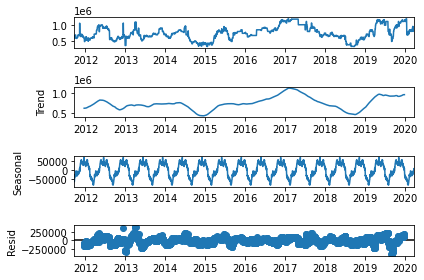

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
# see 6 month seasonal component 
period = 30*6 # how many data in 6 mo
s = seasonal_decompose(y_i,
                       period=period,
                       model='additive')
s.plot()
plt.show()

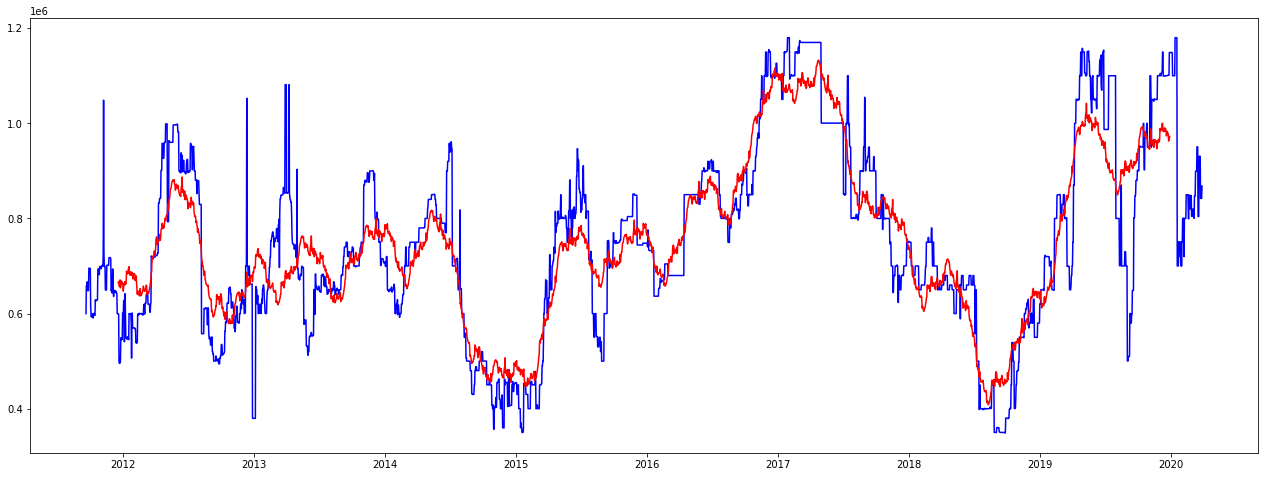

In [19]:
fig = plt.figure(figsize=(22, 8))
ax = fig.gca()

y_pred = s.trend+s.seasonal

ax.plot(y_i,'b-', label='Interpolated daily price')
ax.plot(y_pred, 'r-', label ='seasonal trend')
plt.show()

In [20]:
# create alert bands
def price_alert(df, alps=2):
    y = df.to_numpy()
    y_true = y[:,0]
    y_hat = y[:,1]
    err = y_true - y_hat
    alert = y.copy()
    
    alert = y_hat+ alps * np.nanstd(err)
    
    return alert

In [21]:
subset = y_i.copy()
subset['y_pred'] = y_pred

alert_levels=[0.25, 1, 2]

for alert_level in alert_levels:
    alert_col = 'alert'+str(alert_level)
    alert = price_alert(subset, alert_level)
    subset[alert_col] = alert

In [22]:
subset.head()

,wholesale,y_pred,alert0.25,alert1,alert2
2011-09-21,599585.0,NaN,NaN,NaN,NaN
2011-09-22,658600.0,NaN,NaN,NaN,NaN
2011-09-23,657473.0,NaN,NaN,NaN,NaN
2011-09-24,666448.0,NaN,NaN,NaN,NaN
2011-09-25,666448.0,NaN,NaN,NaN,NaN


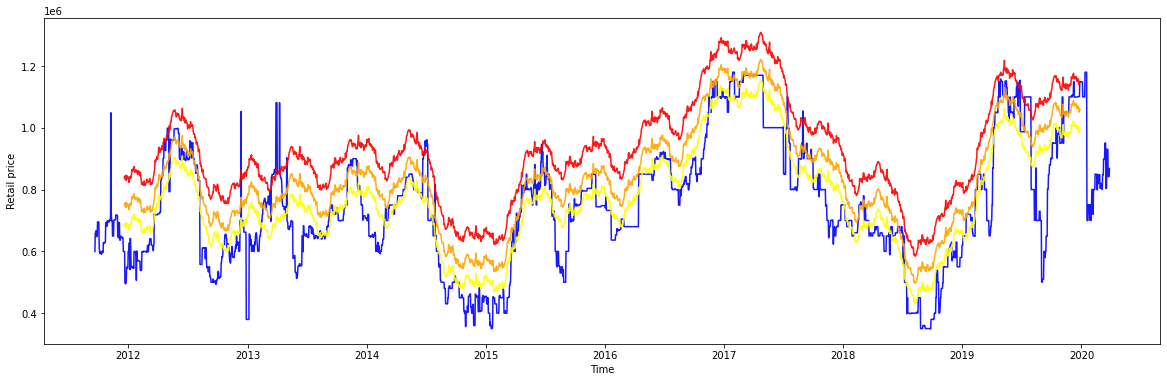

In [23]:
def alert_plot(df):
    fig = plt.figure(figsize=(20,6))
    ax = fig.gca()
    x = df.index
    y = df.iloc[:,0]
    y1 = df.iloc[:,2]
    y2 = df.iloc[:,3]
    y3 = df.iloc[:,4]

    ax.plot(x, y, 'blue', alpha=0.9)
    ax.plot(x, y1, 'yellow', alpha=0.9)
    ax.plot(x, y2, 'orange', alpha=0.9)
    ax.plot(x, y3, 'red', alpha=0.9)
    # ax.fill_between(x, y, y1, where=(y > y1)  & (y < y2), facecolor='yellow', alpha=0.5)
    # ax.fill_between(x, y, y2, where=(y > y2) & (y < y3), facecolor='orange', alpha=0.5)
    # ax.fill_between(x, y, y3, where=y>y3, facecolor='red', alpha=0.5)

    plt.xlabel('Time')
    plt.ylabel('Retail price')

    plt.show()
alert_plot(subset)    

In [24]:
y_i.values.shape

(3111, 1)

In [25]:
# Let's decompose by hand
# use a one-dimensional polynomial estimator least squre approach
order = 10
coef = np.polyfit(np.arange(len(y_i)), y_i.values.ravel(),order)

In [26]:
poly_simulator= np.poly1d(coef)
trend = poly_simulator(np.arange(len(y_i)))

y_decompose = y_i.copy()
y_decompose['trend'] = trend

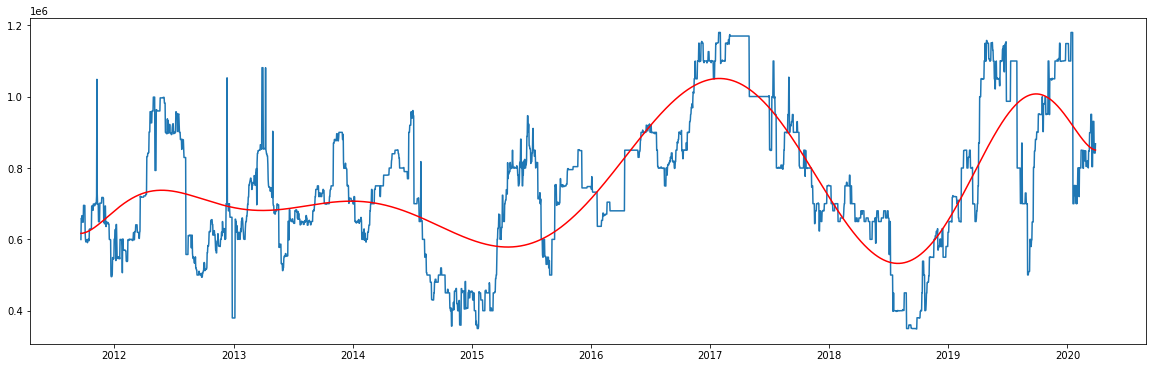

In [27]:
plt.figure(figsize=[20,6])
plt.plot(y_decompose['wholesale'])
plt.plot(y_decompose['trend'],'r')
plt.show()

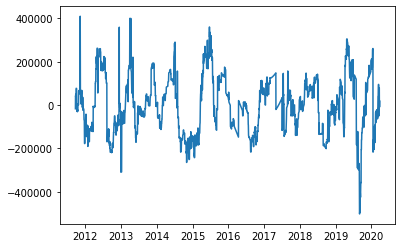

In [28]:
detrended=y_decompose['wholesale']-y_decompose['trend']
plt.plot(detrended)

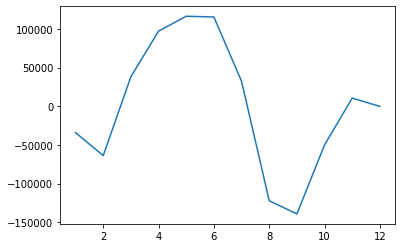

In [29]:
seasonal=detrended.groupby(by=detrended.index.month).median()
plt.plot(seasonal)

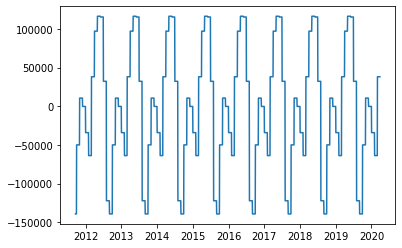

In [30]:
# augament seasonal patterm through the entire time span
seasonal_c = y_i.copy()
col = 'wholesale'
for i in seasonal.index:
    seasonal_c.loc[seasonal_c.index.month==i, col] = seasonal.loc[i]
    
plt.plot(seasonal_c)

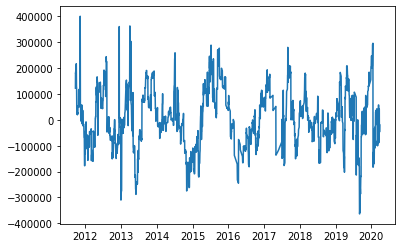

In [31]:
y_decompose['seasonal']=seasonal_c
deseasonal = y_decompose['wholesale']-y_decompose['trend']-y_decompose['seasonal']

plt.plot(deseasonal)

In [32]:
# looks residual still have some trend
order =2
coef2=np.polyfit(np.arange(len(deseasonal)), deseasonal, order)
coef2

array([ 4.63855470e-03, -1.25797218e+01,  5.85666931e+03])

In [33]:
poly_simulator2 = np.poly1d(coef2)
trend_deseasonal = poly_simulator(np.arange(len(deseasonal)))
residual = deseasonal.values.ravel()-trend_deseasonal
y_decompose['trend_deseasonal']=trend_deseasonal
y_decompose['residual']=residual
y_decompose.head()

,wholesale,trend,seasonal,trend_deseasonal,residual
2011-09-21,599585.0,616692.374710,-139189.334365,616692.374710,-494610.415055
2011-09-22,658600.0,616758.956110,-139189.334365,616758.956110,-435728.577855
2011-09-23,657473.0,616846.847822,-139189.334365,616846.847822,-437031.361279
2011-09-24,666448.0,616955.642569,-139189.334365,616955.642569,-428273.950772
2011-09-25,666448.0,617084.937381,-139189.334365,617084.937381,-428532.540396


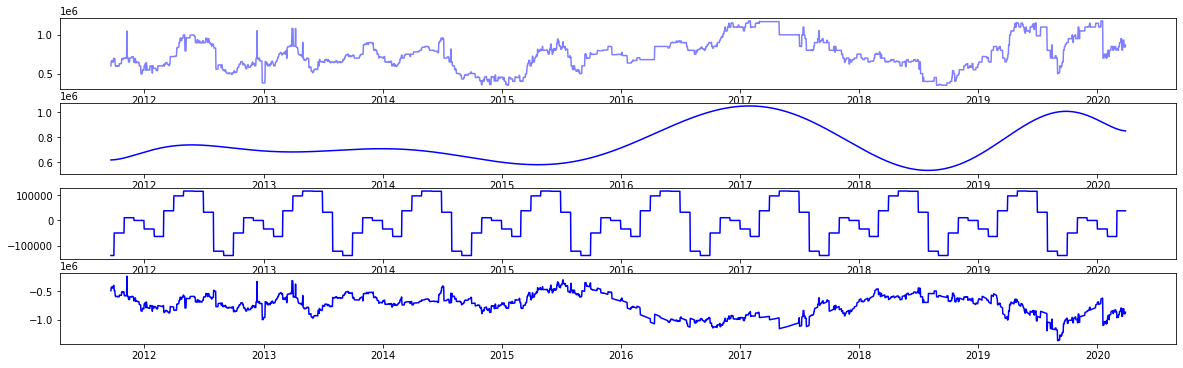

In [38]:
fig = plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(y_decompose['wholesale'], 'b-', alpha=0.5)
plt.subplot(412)
plt.plot(y_decompose['trend'],'b-')
plt.subplot(413)
plt.plot(y_decompose['seasonal'],'b')

plt.subplot(414)
plt.plot(y_decompose['residual'],'b')
plt.show()

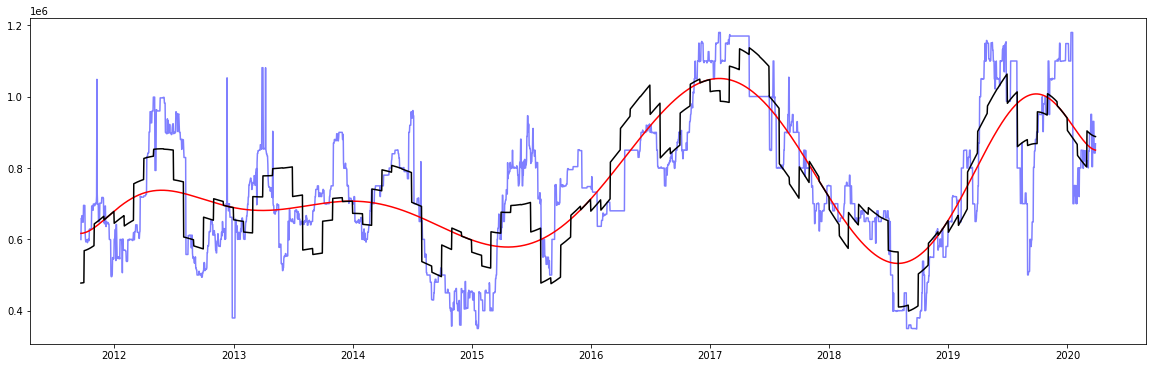

In [34]:
fig = plt.figure(figsize=(20,6))
plt.plot(y_decompose['wholesale'], 'b-', alpha=0.5)
plt.plot(y_decompose['trend'],'r-')
plt.plot(y_decompose['trend']+y_decompose['seasonal'],'k')

plt.show()

In [44]:
new_ss = y_i.copy()
new_ss['y_pred'] = y_decompose['trend']+y_decompose['seasonal']

alert_levels=[0.25, 1, 2]

for alert_level in alert_levels:
    alert_col = 'alert'+str(alert_level)
    alert = price_alert(new_ss, alert_level)
    new_ss[alert_col] = alert

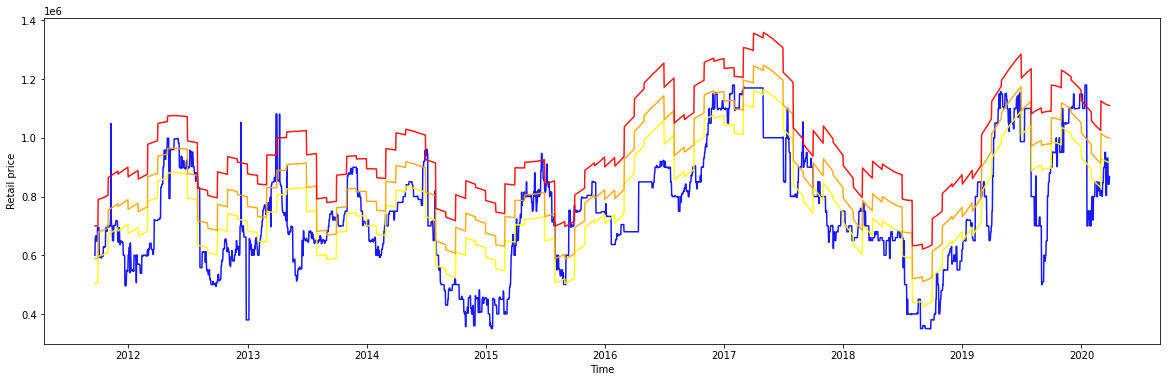

In [45]:
alert_plot(new_ss)